# 1. Analisis de Descriptivo

In [2]:
!pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
df = yf.download('^GSPC', start='2015-01-01', end='2023-12-31')

/var/folders/y8/h4dbqqhd1f53xcjw4m_llk6c0000gn/T/ipykernel_42636/2004054174.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('^GSPC', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


In [6]:
df.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [7]:
df['Return'] = np.log(df['Close']).diff()

### Return Logaritmico

Cuando ves el retorno de manera simple se ve de la siguiente manera:

$R_t = \frac{P_t + P_{t-1}}{P_{t-1}}$

En vez se usa el retorno logaritmico para poder operar con sumas en vez de multipliciaciones:

$r_t = ln(P_t) - ln(P_{t-1})$

In [9]:
df.dropna(inplace=True)

In [10]:
df['Return'].head()

Date
2015-01-05   -0.018447
2015-01-06   -0.008933
2015-01-07    0.011563
2015-01-08    0.017730
2015-01-09   -0.008439
Name: Return, dtype: float64

In [11]:
df['Return'].describe()

count    2263.000000
mean        0.000371
std         0.011579
min        -0.127652
25%        -0.003903
50%         0.000594
75%         0.005793
max         0.089683
Name: Return, dtype: float64

<Axes: >

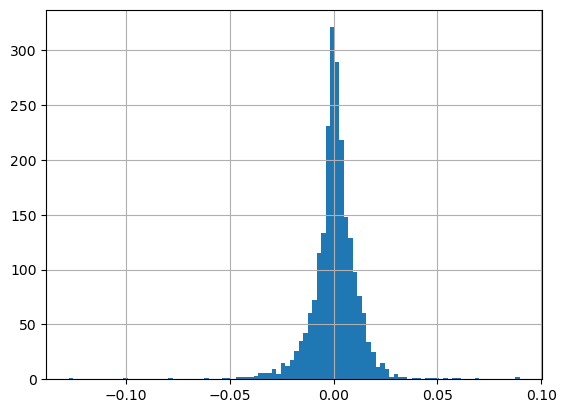

In [12]:
df['Return'].hist(bins=100)

In [13]:
print(f"Sesgo (Skewness): {df['Return'].skew()}")
print(f"Curtosis: {df['Return'].kurt()}")

Sesgo (Skewness): -0.8041141690057201
Curtosis: 15.580588940285486


### Sesgo y Curtosis

El sesgo nos dice (dependiendo del signo) si las caidas son mas significativas que las subidas. Un sesog positivo implica que hay mas subidas que bajadas y un sesgo negativo implíca que las caídas son mas significativas. En este caso el sesgo obtenido es de -0.8 lo cual nos dice que las caidas son bastante mas significativas que las subidas.

El curtosis te dice que tan pesadas son las colas respecto a una distribución normal, el curtosis para la distribución normal es de 0. En este caso el valor de 15 es alto por lo que no solo quiere decir que hay colas diferentes a una distribución normal, si no que son considerablemente probables. 

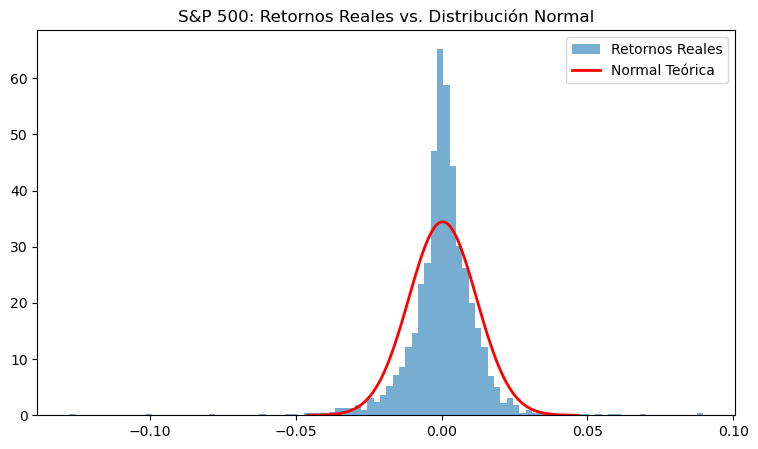

In [15]:
from scipy.stats import norm

mu = df['Return'].mean()
sigma = df['Return'].std()

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)

plt.figure(figsize=(9,5))
plt.hist(df['Return'], bins=100, density=True, alpha=0.6, label='Retornos Reales')
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal Teórica')
plt.title('S&P 500: Retornos Reales vs. Distribución Normal')
plt.legend()
plt.show()

### Analisis de la Tabla

La gráfica roja falla en dos apsectos:

1. El primer aspecto es la amplitud de esta que se corrije fácilmente multimplicando la función de distribución por el valor máximo obtenido.
2. El segundo es que no llega a tomar en cuenta las colas por lo que sabemos que la distribución normal no es una buena forma de estimar este movimineto del retorno.

In [17]:
volatilidad_anual = df['Return'].std() * np.sqrt(252) * 100
print(f"Volatilidad Anualizada: {volatilidad_anual:.2f}%")

Volatilidad Anualizada: 18.38%


### Volatilidad

En finanzas se trabaja con la volatilidad anual en vez de la volatilidad diria. Se toma en cuenta que hay 252 días hábiles en los cuales el mercado opera dentro de un año. Se obtuvo el 18.38% lo cual implica que hay voltailidad pero al mismo tiempo no es algo que domina el mercado, esta entre los parametros de normalidad. Si hicieras el mismo analisis pero solo para el año 2020 (año donde empieza el COVID) el porenctaje sería mucho mayor porque hubo una caida del mercado bastante grande. 

# 2. Simulación y Gestión de Riesgos

In [20]:
S0 = float(df['Close'].iloc[-1])

/var/folders/y8/h4dbqqhd1f53xcjw4m_llk6c0000gn/T/ipykernel_42636/3421819732.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(df['Close'].iloc[-1])


In [21]:
mu = df['Return'].mean()
sigma = df['Return'].std()
n_sims = 10000
Z = np.random.standard_normal(size=10000)

S1 = S0 * np.exp((mu - (sigma**2 / 2)) * 1 + sigma * np.sqrt(1) * Z)

In [22]:
#Peores valores en el 5%
var_95_precio = np.percentile(S1, 5)

perdida_maxima = S0 - var_95_precio
print(f"Perdida Máxima: {perdida_maxima:.2f}")

Perdida Máxima: 89.80


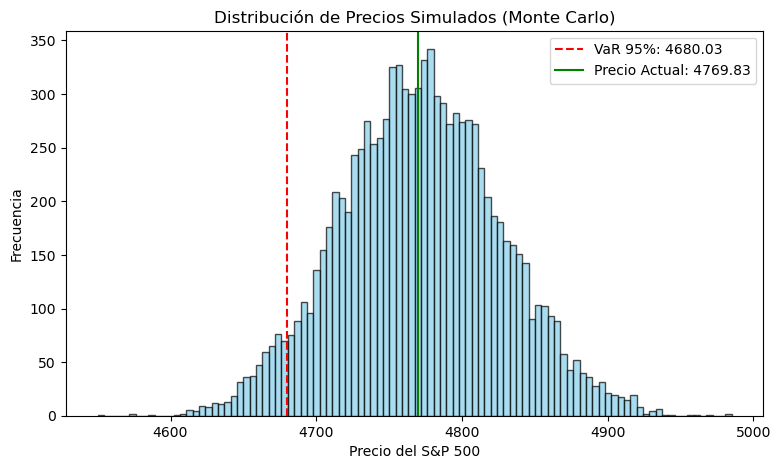

In [23]:
plt.figure(figsize=(9,5))
plt.hist(S1, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(var_95_precio, color='red', linestyle='--', label=f'VaR 95%: {var_95_precio:.2f}')
plt.axvline(S0, color='green', label=f'Precio Actual: {S0:.2f}')
plt.title('Distribución de Precios Simulados (Monte Carlo)')
plt.xlabel('Precio del S&P 500')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

### Ahora hagamoslo para 21 días

In [25]:
T = 21
Z = np.random.standard_normal(size=(T, n_sims))

retornos_diarios = (mu - 0.5 * sigma**2) * 1 + sigma * np.sqrt(1) * Z

In [26]:
Z_acumulado = retornos_diarios.cumsum(axis=0)

S_trayectorias = S0 * np.exp(Z_acumulado)

In [27]:
fila_inicio = np.full((1, n_sims), S0)

S_final = np.vstack([fila_inicio, S_trayectorias])
S_final.shape

(22, 10000)

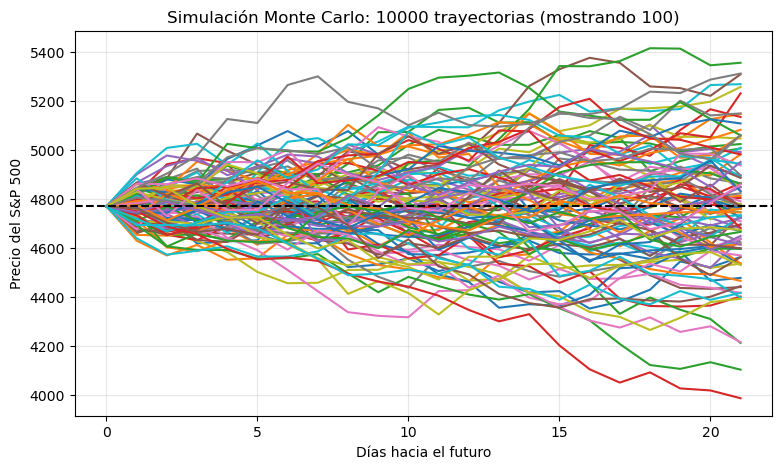

In [28]:
dias = np.arange(0, T + 1)

plt.figure(figsize=(9,5))
plt.plot(dias, S_final[:,:100])
plt.axhline(S0, color='black', linestyle='--')

plt.title(f'Simulación Monte Carlo: {n_sims} trayectorias (mostrando 100)')
plt.xlabel('Días hacia el futuro')
plt.ylabel('Precio del S&P 500')
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
precios_finales = S_final[-1,:]

var_95_30d = np.percentile(precios_finales, 5)
perdida_mensual = S0 - var_95_30d

print(f"Pérdida máxima esperada en 21 días: {perdida_mensual:.2f}")

Pérdida máxima esperada en 21 días: 377.18


# 3. Optimización de Portafolios

In [31]:
df = yf.download({'AAPL', 'NVDA', 'GLD', 'TLT'}, start='2018-01-01', end='2025-12-15')['Close']

/var/folders/y8/h4dbqqhd1f53xcjw4m_llk6c0000gn/T/ipykernel_42636/2724419602.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download({'AAPL', 'NVDA', 'GLD', 'TLT'}, start='2018-01-01', end='2025-12-15')['Close']
[*********************100%***********************]  4 of 4 completed


In [32]:
portfolio_returns = np.log(df / df.shift(1)).dropna()
portfolio_returns.head()

Ticker,AAPL,GLD,NVDA,TLT
Date,,,,
2018-01-03,-0.000174,-0.002640,0.063739,0.004770
2018-01-04,0.004634,0.005114,0.005258,-0.000159
2018-01-05,0.011321,-0.001037,0.008438,-0.002860
2018-01-08,-0.003722,-0.000160,0.030181,-0.000637
2018-01-09,-0.000115,-0.004639,-0.000270,-0.013463


In [33]:
matriz_corr = portfolio_returns.corr()
print(matriz_corr)

Ticker      AAPL       GLD      NVDA       TLT
Ticker                                        
AAPL    1.000000  0.065842  0.574886 -0.091619
GLD     0.065842  1.000000  0.058975  0.254595
NVDA    0.574886  0.058975  1.000000 -0.071523
TLT    -0.091619  0.254595 -0.071523  1.000000


In [34]:
matriz_cov_anual = portfolio_returns.cov()*252

In [35]:
num_portfolios = 5000
resultados = np.zeros((3, num_portfolios))
pesos_lista = []

for i in range(num_portfolios):
    pesos = np.random.random(4)
    pesos /= np.sum(pesos)
    pesos_lista.append(pesos)
    
    retorno = np.sum(portfolio_returns.mean() * pesos) * 252
    
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov_anual, pesos)))
    
    resultados[0,i] = retorno
    resultados[1,i] = volatilidad
    resultados[2,i] = retorno / volatilidad

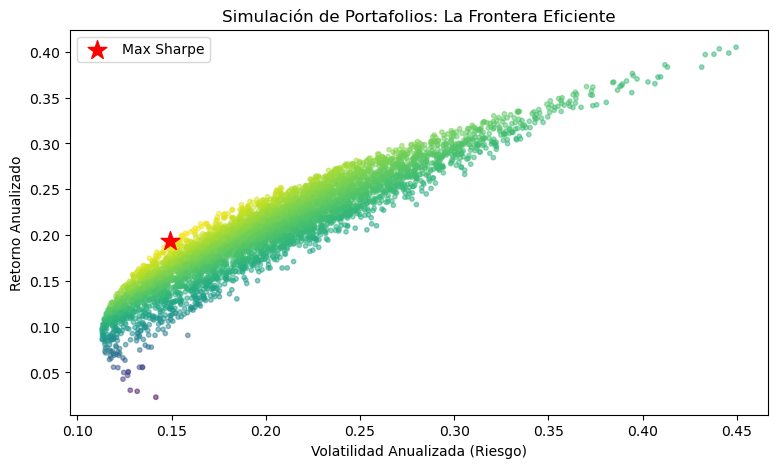

In [36]:
plt.figure(figsize=(9,5))
plt.scatter(resultados[1,:], resultados[0,:], c=resultados[2,:], cmap='viridis', marker='o', s=10, alpha=0.5)

max_sharpe_idx = resultados[2,:].argmax()
plt.scatter(resultados[1,max_sharpe_idx], resultados[0,max_sharpe_idx], color='red', marker='*', s=200, label='Max Sharpe')

plt.title('Simulación de Portafolios: La Frontera Eficiente')
plt.xlabel('Volatilidad Anualizada (Riesgo)')
plt.ylabel('Retorno Anualizado')
plt.legend()
plt.show()

In [37]:
print(pesos_lista[max_sharpe_idx])

[0.17576997 0.70254106 0.10783884 0.01385013]


In [38]:
pesos_optimos = pesos_lista[max_sharpe_idx]

ret_equitativo = (portfolio_returns * 0.25).sum(axis=1)
ret_optimo = (portfolio_returns * pesos_optimos).sum(axis=1)

cum_equitativo = np.exp(ret_equitativo.cumsum())
cum_optimo = np.exp(ret_optimo.cumsum())

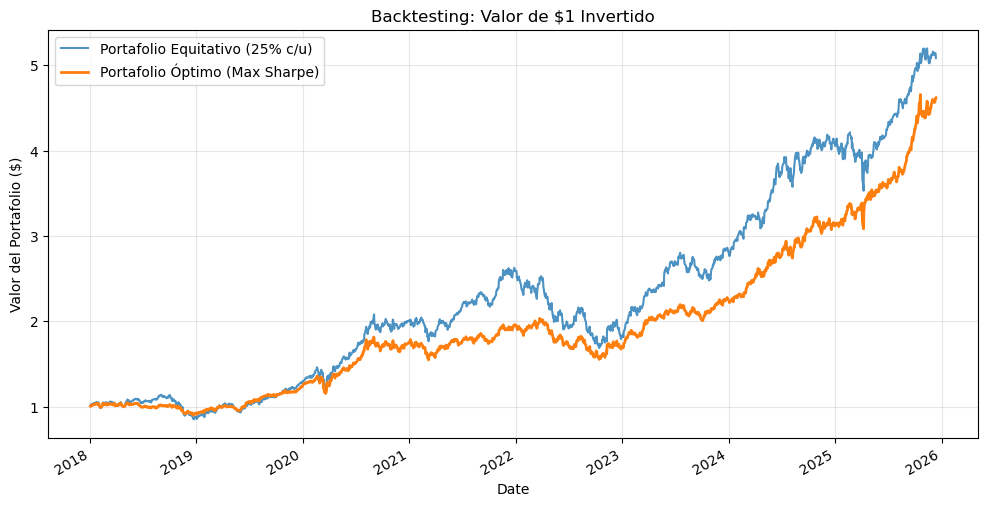

In [39]:
plt.figure(figsize=(12, 6))
cum_equitativo.plot(label='Portafolio Equitativo (25% c/u)', alpha=0.8)
cum_optimo.plot(label='Portafolio Óptimo (Max Sharpe)', linewidth=2)

plt.title('Backtesting: Valor de $1 Invertido')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
def calcular_drawdown(serie_acumulada):
    picos = serie_acumulada.cummax()
    drawdowns = (serie_acumulada - picos) / picos
    return drawdowns

dd_equitativo = calcular_drawdown(cum_equitativo)
dd_optimo = calcular_drawdown(cum_optimo)

print(f"Peor caída Equitativo: {dd_equitativo.min():.2%}")
print(f"Peor caída Óptimo: {dd_optimo.min():.2%}")

Peor caída Equitativo: -35.79%
Peor caída Óptimo: -23.58%


# 4. Modelo GARCH

In [42]:
!pip install arch

In [43]:
from arch import arch_model

In [44]:
retorno_NVDA = portfolio_returns['NVDA'] * 100
modelo_nvda = arch_model(retorno_NVDA, vol='Garch', p=1, q=1, dist='t')
resultado_nvda = modelo_nvda.fit(disp='off')
vol_condicional = resultado_nvda.conditional_volatility * np.sqrt(252)
nu = resultado_nvda.params['nu']

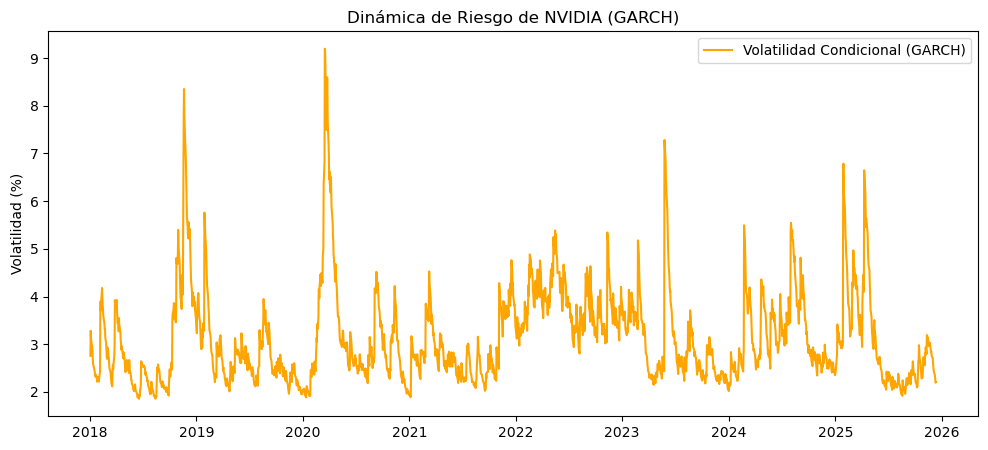

In [45]:
plt.figure(figsize=(12, 5))
plt.plot(resultado_nvda.conditional_volatility, color='orange', label='Volatilidad Condicional (GARCH)')
plt.title('Dinámica de Riesgo de NVIDIA (GARCH)')
plt.ylabel('Volatilidad (%)')
plt.legend()
plt.show()

In [46]:
pronostico = resultado_nvda.forecast(horizon=30)

varianza_proyectada = pronostico.variance.values[-1,:]
vol_proyectada = np.sqrt(varianza_proyectada)

In [47]:
omega = resultado_nvda.params['omega']
alpha = resultado_nvda.params['alpha[1]']
beta = resultado_nvda.params['beta[1]']

dias = 30
n_simulaciones = 1000
ultimo_precio = df['NVDA'].iloc[-1]
ultima_vol = resultado_nvda.conditional_volatility.iloc[-1]
ultimo_retorno = retorno_NVDA.iloc[-1]

precios_garch = np.zeros((dias, n_simulaciones))
precios_garch[0] = ultimo_precio

for s in range(n_simulaciones):
    vol_t = ultima_vol
    ret_t = ultimo_retorno
    
    for t in range(1, dias):
        var_t = omega + alpha * (ret_t**2) + beta * (vol_t**2)
        vol_t = np.sqrt(var_t)
        
        z = np.random.standard_t(df=nu)
        ret_t = vol_t * z 
        
        precios_garch[t, s] = precios_garch[t-1, s] * np.exp(ret_t / 100)

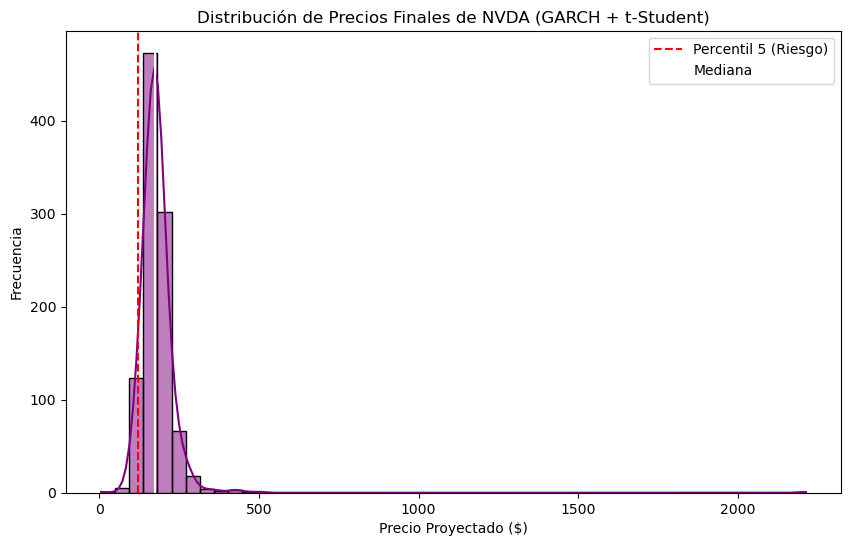

In [48]:
import seaborn as sns

precios_finales = precios_garch[-1, :]

plt.figure(figsize=(10, 6))
sns.histplot(precios_finales, kde=True, color='purple', bins=50)

plt.axvline(np.percentile(precios_finales, 5), color='red', linestyle='--', label='Percentil 5 (Riesgo)')
plt.axvline(np.median(precios_finales), color='white', linestyle='-', label='Mediana')

plt.title('Distribución de Precios Finales de NVDA (GARCH + t-Student)')
plt.xlabel('Precio Proyectado ($)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [49]:
var_95 = np.percentile(precios_finales, 5)
caida_porcentual = (var_95 - ultimo_precio) / ultimo_precio * 100
print(f"En el peor 5% de los casos, el precio cae por debajo de: ${var_95:.2f}")
print(f"Esto representa una caída del {caida_porcentual:.2f}%")

En el peor 5% de los casos, el precio cae por debajo de: $120.55
Esto representa una caída del -31.12%


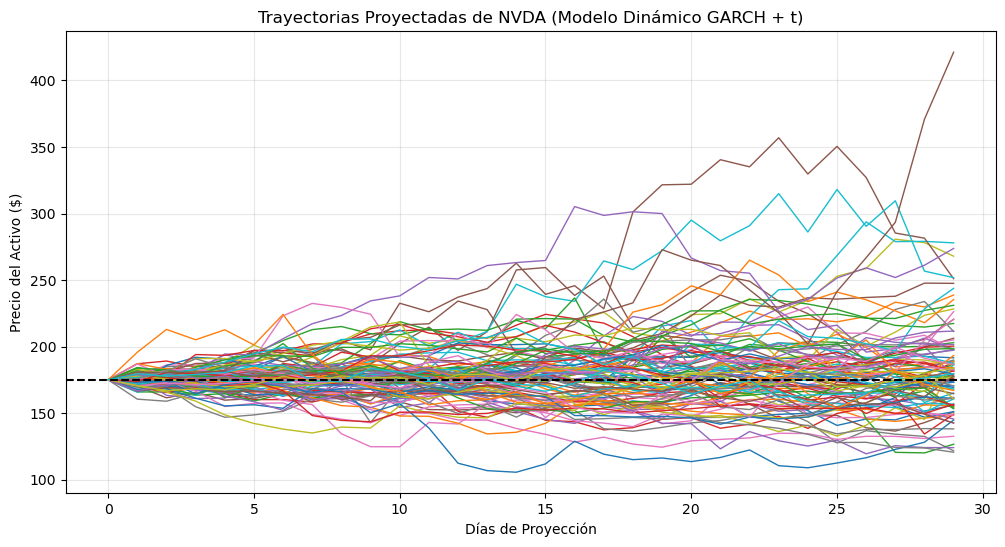

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(precios_garch[:, :100], lw=1)
plt.axhline(175, color='black', linestyle='--')

plt.title('Trayectorias Proyectadas de NVDA (Modelo Dinámico GARCH + t)')
plt.xlabel('Días de Proyección')
plt.ylabel('Precio del Activo ($)')
plt.grid(True, alpha=0.3)
plt.show()

In [51]:
print(ultimo_precio)

175.02000427246094


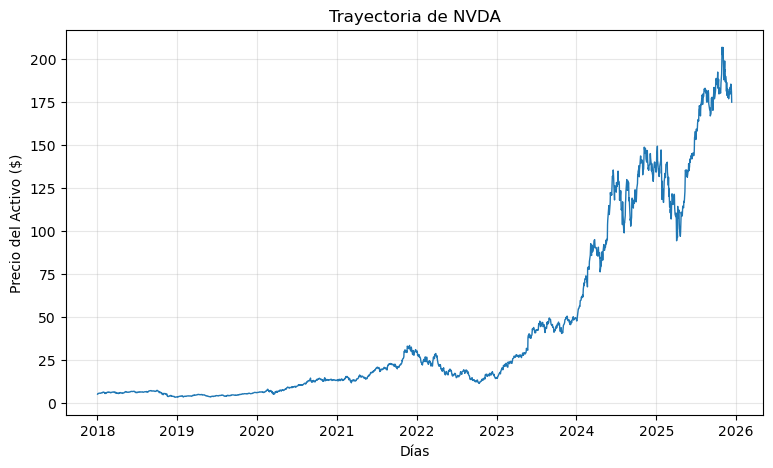

In [52]:
plt.figure(figsize=(9,5))
plt.plot(df['NVDA'], lw=1)

plt.title('Trayectoria de NVDA')
plt.xlabel('Días')
plt.ylabel('Precio del Activo ($)')
plt.grid(True, alpha=0.3)
plt.show()

In [53]:
!pip install nltk

In [54]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analizador = SentimentIntensityAnalyzer()

noticia_ingles = "Panic in the market as stocks crash and investors lose money."

puntaje = analizador.polarity_scores(noticia_ingles)

print(f"Noticia: {noticia_ingles}")
print(f"Sentimiento: {puntaje}")

Noticia: Panic in the market as stocks crash and investors lose money.
Sentimiento: {'neg': 0.521, 'neu': 0.479, 'pos': 0.0, 'compound': -0.8271}


In [55]:
!pip install transformers torch

In [56]:
def calcular_sentimiento_diario(noticias_del_dia, pesos_fuentes):
    suma_ponderada = 0
    suma_pesos = 0
    
    peso_default = 0.2 
    
    for noticia in noticias_del_dia:
        fuente = noticia['fuente']
        score = noticia['score_finbert']
        
        peso = pesos_fuentes.get(fuente, peso_default)
        
        suma_ponderada += (score * peso)
        suma_pesos += peso
        
    if suma_pesos == 0:
        return 0.0
        
    sentimiento_final = suma_ponderada / suma_pesos
    
    return sentimiento_final

In [57]:
pesos_fuentes = {
    "Bloomberg": 1.0,
    "Reuters": 1.0,
    "WSJ": 1.0,

    "CNBC": 0.7,
    "Yahoo Finance": 0.7,
    "TechCrunch": 0.7,

    "Reddit": 0.3,
    "Twitter": 0.3,
    "SeekingAlpha": 0.3
}

noticias_prueba = [
    {
        "fuente": "Bloomberg",
        "texto": "Supply chain issues persist for major chipmakers.",
        "score_finbert": -0.85
    },
    {
        "fuente": "Reddit",
        "texto": "NVIDIA going to the moon! 🚀🚀🚀",
        "score_finbert": 0.95
    },
    {
        "fuente": "CNBC",
        "texto": "Analysts are cautiously optimistic about tech earnings.",
        "score_finbert": 0.30
    },
    {
        "fuente": "El Blog de Pepe",
        "texto": "¡Vendan todo! Se acaba el mundo.",
        "score_finbert": -0.99
    }
]

In [58]:
omega = resultado_nvda.params['omega']
alpha = resultado_nvda.params['alpha[1]']
beta = resultado_nvda.params['beta[1]']
gamma = 0.8

n_simulaciones = 10000
ultimo_precio = df['NVDA'].iloc[-1]
ultima_vol = resultado_nvda.conditional_volatility.iloc[-1]
ultimo_retorno = retorno_NVDA.iloc[-1]

precios_garch2 = np.zeros(n_simulaciones)

sentimiento_dia = calcular_sentimiento_diario(noticias_prueba, pesos_fuentes)
var_t = omega + alpha * (ultimo_retorno**2) + beta * (ultima_vol**2) - gamma * sentimiento_dia
vol_t = np.sqrt(max(var_t, 1e-6))

for s in range(n_simulaciones):
    z = np.random.standard_t(df=nu)
    ret_t = vol_t * z 
    
    precios_garch2[s] = ultimo_precio * np.exp(ret_t / 100)

<Axes: ylabel='Count'>

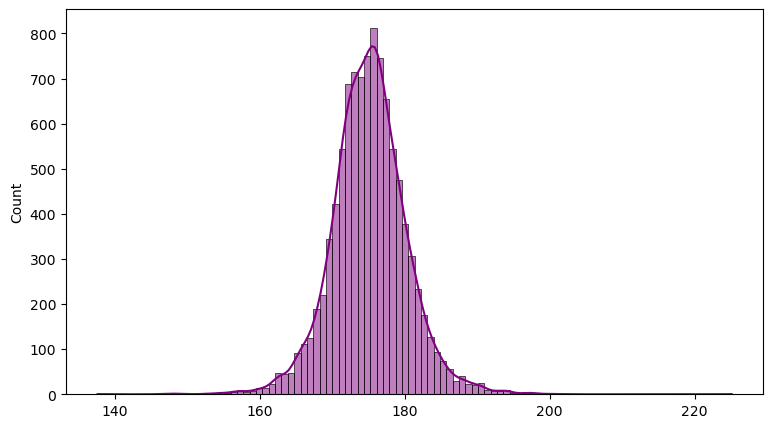

In [59]:
plt.figure(figsize=(9,5))
sns.histplot(precios_garch2, kde=True, color='purple', bins=100)

In [60]:
var_95_garch2 = np.percentile(precios_garch2, 5)
caida_porcentual = (var_95_garch2 - ultimo_precio) / ultimo_precio * 100
print(f"En el peor 5% de los casos, el precio cae por debajo de: ${var_95_garch2:.2f}")
print(f"Esto representa una caída del {caida_porcentual:.2f}%")

En el peor 5% de los casos, el precio cae por debajo de: $166.86
Esto representa una caída del -4.66%


In [61]:
valor_95_medio = np.mean(precios_garch2[precios_garch2<var_95_garch2])
valor_95_medio

163.75414141508972

In [62]:
tickers = ['NVDA', 'MSFT', 'AMZN', 'JPM', 'JNJ', 'KO', 'XOM', 'VNQ', 'GLD', 'TLT']

datos = yf.download(tickers, start="2021-01-01", end="2024-01-01")['Close']

/var/folders/y8/h4dbqqhd1f53xcjw4m_llk6c0000gn/T/ipykernel_42636/463865986.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(tickers, start="2021-01-01", end="2024-01-01")['Close']
[*********************100%***********************]  10 of 10 completed


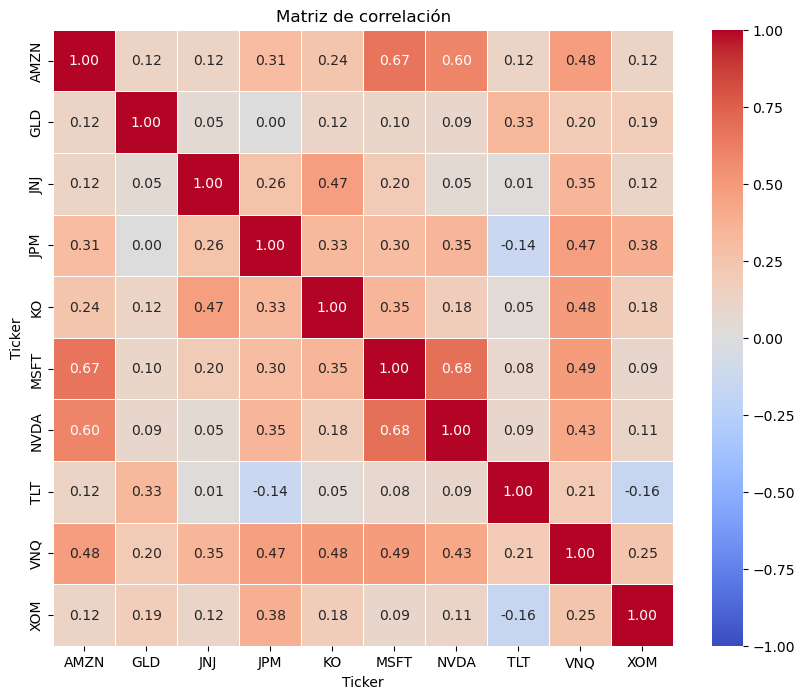

In [63]:
retornos = np.log(datos / datos.shift(1)).dropna()

correlacion = retornos.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlacion,
           annot = True,
           cmap = 'coolwarm',
           vmin = -1, vmax = 1,
           center = 0,
           fmt = '.2f',
           linewidths = 0.5)
plt.title('Matriz de correlación')
plt.show()

In [64]:
matriz_cov_anual_10 = retornos.cov()*252
num_portfolios = 10000
resultados_10 = np.zeros((3, num_portfolios))
pesos_lista = []

for i in range(num_portfolios):
    pesos = np.random.random(10)
    pesos /= np.sum(pesos)
    pesos_lista.append(pesos)
    
    retorno = np.sum(retornos.mean() * pesos) * 252
    
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov_anual_10, pesos)))
    
    resultados_10[0,i] = retorno
    resultados_10[1,i] = volatilidad
    resultados_10[2,i] = retorno / volatilidad

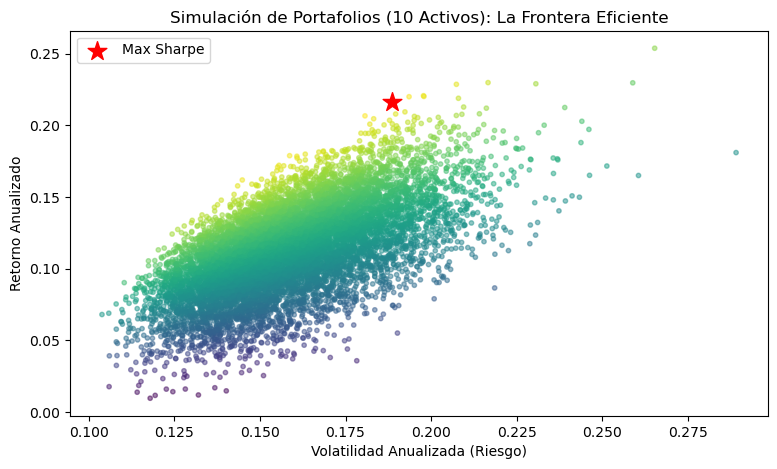

In [68]:
plt.figure(figsize=(9,5))
plt.scatter(resultados_10[1,:], resultados_10[0,:], c=resultados_10[2,:], cmap='viridis', marker='o', s=10, alpha=0.5)

max_sharpe_idx_10 = resultados_10[2,:].argmax()
plt.scatter(resultados_10[1,max_sharpe_idx_10], resultados_10[0,max_sharpe_idx_10], color='red', marker='*', s=200, label='Max Sharpe')

plt.title('Simulación de Portafolios (10 Activos): La Frontera Eficiente')
plt.xlabel('Volatilidad Anualizada (Riesgo)')
plt.ylabel('Retorno Anualizado')
plt.legend()
plt.show()

In [70]:
print(pesos_lista[max_sharpe_idx_10])

[0.00776315 0.1042433  0.04221798 0.09387751 0.09165064 0.15851972
 0.1950609  0.03667739 0.03193467 0.23805473]


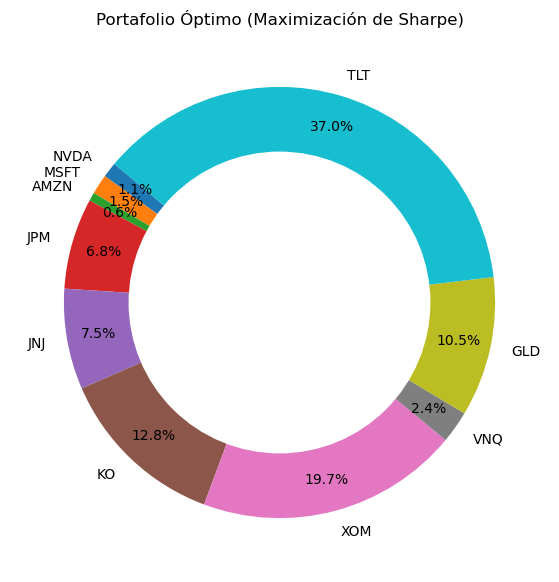

In [72]:
pesos_optimos = [0.01139733, 0.01496495, 0.00633354, 0.06816813, 0.07547014, 
                 0.12783391, 0.19681917, 0.02415991, 0.10480512, 0.3700478]
tickers = ['NVDA', 'MSFT', 'AMZN', 'JPM', 'JNJ', 'KO', 'XOM', 'VNQ', 'GLD', 'TLT']

plt.figure(figsize=(10, 7))
plt.pie(pesos_optimos, labels=tickers, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Portafolio Óptimo (Maximización de Sharpe)")
plt.show()

Viajando al pasado para recoger datos... ⏳


/var/folders/y8/h4dbqqhd1f53xcjw4m_llk6c0000gn/T/ipykernel_42636/50220741.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(tickers_todos, start="2023-01-01", end="2024-06-01")['Close']
[*********************100%***********************]  11 of 11 completed


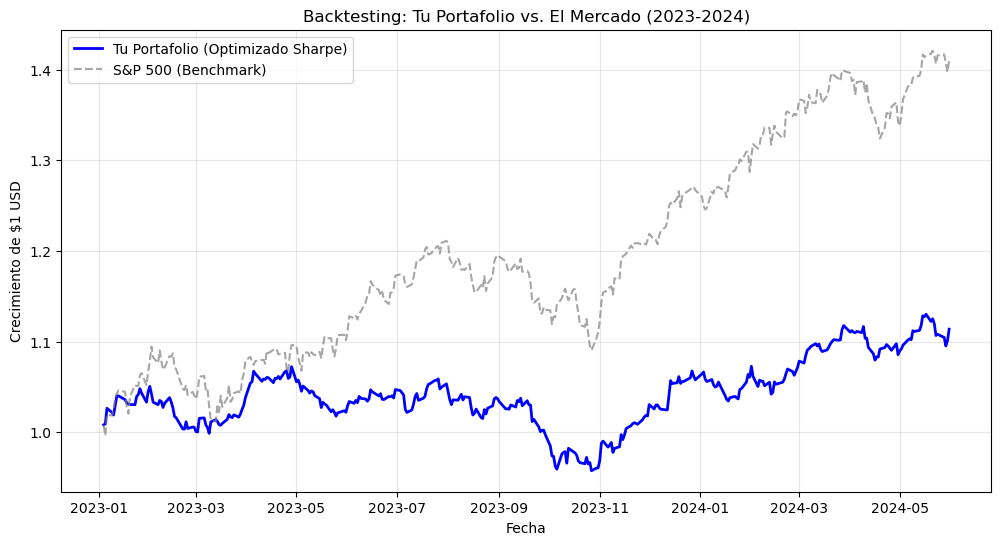

Rendimiento Final de Tu Portafolio: 11.37%
Rendimiento Final del S&P 500:      41.02%


In [74]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

tickers = ['NVDA', 'MSFT', 'AMZN', 'JPM', 'JNJ', 'KO', 'XOM', 'VNQ', 'GLD', 'TLT']
pesos = [0.0113, 0.0149, 0.0063, 0.0681, 0.0754, 0.1278, 0.1968, 0.0241, 0.1048, 0.3700]

tickers_todos = tickers + ['SPY']

print("Viajando al pasado para recoger datos... ⏳")
datos = yf.download(tickers_todos, start="2023-01-01", end="2024-06-01")['Close']

retornos = datos.pct_change().dropna()

retorno_portafolio = (retornos[tickers] * pesos).sum(axis=1)
retorno_benchmark = retornos['SPY']

acumulado_portafolio = (1 + retorno_portafolio).cumprod()
acumulado_benchmark = (1 + retorno_benchmark).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(acumulado_portafolio, label='Tu Portafolio (Optimizado Sharpe)', color='blue', linewidth=2)
plt.plot(acumulado_benchmark, label='S&P 500 (Benchmark)', color='gray', linestyle='--', alpha=0.7)

plt.title('Backtesting: Tu Portafolio vs. El Mercado (2023-2024)')
plt.ylabel('Crecimiento de $1 USD')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

rendimiento_final = (acumulado_portafolio.iloc[-1] - 1) * 100
rendimiento_spy = (acumulado_benchmark.iloc[-1] - 1) * 100

print(f"Rendimiento Final de Tu Portafolio: {rendimiento_final:.2f}%")
print(f"Rendimiento Final del S&P 500:      {rendimiento_spy:.2f}%")

In [76]:
def calcular_drawdown(serie_acumulada):
    picos = serie_acumulada.cummax()
    drawdowns = (serie_acumulada - picos) / picos
    return drawdowns

dd_spy = calcular_drawdown(acumulado_portafolio)
dd_optimo_10 = calcular_drawdown(acumulado_benchmark)

print(f"Peor caída Equitativo: {dd_equitativo.min():.2%}")
print(f"Peor caída Óptimo: {dd_optimo.min():.2%}")

Peor caída Equitativo: -35.79%
Peor caída Óptimo: -23.58%


/var/folders/y8/h4dbqqhd1f53xcjw4m_llk6c0000gn/T/ipykernel_42636/3453416435.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(tickers, start="2023-01-01", end="2024-06-01")['Close']
[*********************100%***********************]  10 of 10 completed

Simulando estrategia de rebalanceo... ⚖️


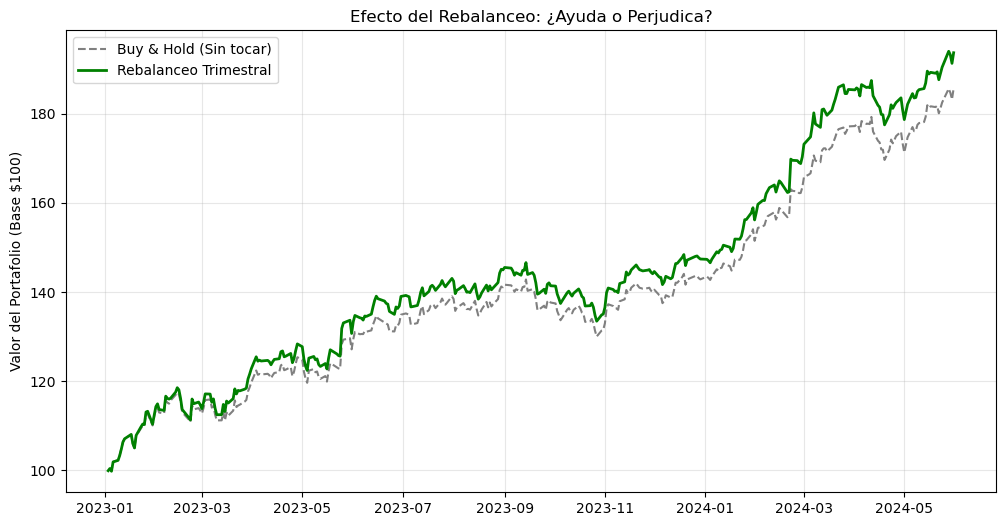

Rendimiento Buy & Hold:    85.64%
Rendimiento Rebalanceado:  93.63%
Diferencia:                8.00%


In [78]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

tickers = ['NVDA', 'MSFT', 'AMZN', 'JPM', 'JNJ', 'KO', 'XOM', 'VNQ', 'GLD', 'TLT']
pesos = np.array([0.0113, 0.0149, 0.0063, 0.0681, 0.0754, 0.1278, 0.1968, 0.0241, 0.1048, 0.3700])

print("Simulando estrategia de rebalanceo... ⚖️")
datos = yf.download(tickers, start="2023-01-01", end="2024-06-01")['Close']
datos.dropna(inplace=True)

retornos_diarios = datos.pct_change().dropna()
bh_portfolio = (1 + (retornos_diarios * pesos).sum(axis=1)).cumprod() * 100

fechas_rebalanceo = datos.resample('Q').last().index # 'QE' es Quarter End

capital_inicial = 100
valor_rebalanceado = pd.Series(dtype=float)
capital_actual = capital_inicial

fecha_inicio_periodo = datos.index[0]

for fecha_fin in fechas_rebalanceo:
    if fecha_fin > datos.index[-1]:
        fecha_fin = datos.index[-1]
    
    periodo = datos.loc[fecha_inicio_periodo:fecha_fin]
    
    if len(periodo) > 0:
        retorno_periodo = periodo / periodo.iloc[0]
        
        valor_diario = (retorno_periodo * (capital_actual * pesos)).sum(axis=1)
        
        valor_rebalanceado = pd.concat([valor_rebalanceado, valor_diario])
        
        capital_actual = valor_diario.iloc[-1]
        
        fecha_inicio_periodo = fecha_fin

if fecha_inicio_periodo < datos.index[-1]:
    periodo = datos.loc[fecha_inicio_periodo:]
    retorno_periodo = periodo / periodo.iloc[0]
    valor_diario = (retorno_periodo * (capital_actual * pesos)).sum(axis=1)
    valor_rebalanceado = pd.concat([valor_rebalanceado, valor_diario])

valor_rebalanceado = valor_rebalanceado[~valor_rebalanceado.index.duplicated(keep='first')]

plt.figure(figsize=(12, 6))

plt.plot(bh_portfolio, label='Buy & Hold (Sin tocar)', color='gray', linestyle='--')

plt.plot(valor_rebalanceado, label='Rebalanceo Trimestral', color='green', linewidth=2)

plt.title('Efecto del Rebalanceo: ¿Ayuda o Perjudica?')
plt.ylabel('Valor del Portafolio (Base $100)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

ret_bh = (bh_portfolio.iloc[-1] - 100)
ret_reb = (valor_rebalanceado.iloc[-1] - 100)

print(f"Rendimiento Buy & Hold:    {ret_bh:.2f}%")
print(f"Rendimiento Rebalanceado:  {ret_reb:.2f}%")
print(f"Diferencia:                {ret_reb - ret_bh:.2f}%")